reference: https://github.com/Andras7/word2vec-pytorch

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.nn import init
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from tqdm import tnrange, tqdm_notebook
import numpy as np

In [0]:
class DataReader:
    NEGATIVE_TABLE_SIZE = 1e8

    def __init__(self, inputFileName, min_count):

        self.negatives = []
        self.discards = []
        self.negpos = 0

        self.word2id = dict()
        self.id2word = dict()
        self.sentences_count = 0
        self.token_count = 0
        self.word_frequency = dict()

        self.inputFileName = inputFileName
        self.read_words(min_count)
        self.initTableNegatives()
        self.initTableDiscards()

    def read_words(self, min_count):
        word_frequency = dict()
        for line in open(self.inputFileName, encoding="utf8"):
            line = line.split()
            if len(line) > 1:
                self.sentences_count += 1
                for word in line:
                    if len(word) > 0:
                        self.token_count += 1
                        word_frequency[word] = word_frequency.get(word, 0) + 1

                        if self.token_count % 1000000 == 0:
                            print("Read " + str(int(self.token_count / 1000000)) + "M words.")

        wid = 0
        for w, c in word_frequency.items():
            if c < min_count:
                continue
            self.word2id[w] = wid
            self.id2word[wid] = w
            self.word_frequency[wid] = c
            wid += 1
        print("Total embeddings: " + str(len(self.word2id)))

    def initTableDiscards(self):
        t = 0.0001
        f = np.array(list(self.word_frequency.values())) / self.token_count
        self.discards = np.sqrt(t / f) + (t / f)

    def initTableNegatives(self):
        pow_frequency = np.array(list(self.word_frequency.values())) ** 0.5
        words_pow = sum(pow_frequency)
        ratio = pow_frequency / words_pow
        count = np.round(ratio * DataReader.NEGATIVE_TABLE_SIZE)
        for wid, c in enumerate(count):
            self.negatives += [wid] * int(c)
        self.negatives = np.array(self.negatives)
        np.random.shuffle(self.negatives)

    def getNegatives(self, target, size):  # TODO check equality with target
        response = self.negatives[self.negpos:self.negpos + size]
        self.negpos = (self.negpos + size) % len(self.negatives)
        if len(response) != size:
            return np.concatenate((response, self.negatives[0:self.negpos]))
        return response

In [0]:
class Word2vecDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size
        self.input_file = open(data.inputFileName, encoding="utf8")

    def __len__(self):
        return self.data.sentences_count

    def __getitem__(self, idx):
        while True:
            line = self.input_file.readline()
            if not line:
                self.input_file.seek(0, 0)
                line = self.input_file.readline()

            if len(line) > 1:
                words = line.split()

                if len(words) > 1:
                    word_ids = [self.data.word2id[w] for w in words if
                                w in self.data.word2id and np.random.rand() < self.data.discards[self.data.word2id[w]]]

                    boundary = np.random.randint(1, self.window_size)
                    return [(u, v, self.data.getNegatives(v, 5)) for i, u in enumerate(word_ids) for j, v in
                            enumerate(word_ids[max(i - boundary, 0):i + boundary]) if u != v]

    @staticmethod
    def collate(batches):
        all_u = [u for batch in batches for u, _, _ in batch if len(batch) > 0]
        all_v = [v for batch in batches for _, v, _ in batch if len(batch) > 0]
        all_neg_v = [neg_v for batch in batches for _, _, neg_v in batch if len(batch) > 0]

        return torch.LongTensor(all_u), torch.LongTensor(all_v), torch.LongTensor(all_neg_v)

In [4]:
window_size = 5
batch_size = 32
min_count=12

data = DataReader("input.txt", min_count=min_count)
dataset = Word2vecDataset(data, window_size) 
dataloader = DataLoader(dataset, batch_size=batch_size,
                                     shuffle=False, num_workers=0, collate_fn=dataset.collate)

Read 1M words.
Total embeddings: 7167


### check 1 batch

In [0]:
d = next(iter(dataloader))

```py
d[0] : center word
d[1] : neighbor word
d[2] : negative sample words
```

In [6]:
d

(tensor([   0,    0,    0,  ..., 1741, 1741, 1741]),
 tensor([   4,    5,    6,  ..., 2856, 3225,   54]),
 tensor([[ 885, 3362,  810, 5199, 1454],
         [   6, 4020, 6210, 4366,  217],
         [ 376, 1478, 1042, 1932, 6890],
         ...,
         [4917, 6752,  599,  851, 5202],
         [5679,  601, 1785,  867, 4626],
         [1572, 2684, 6470, 2524, 3053]]))

In [7]:
d[0].shape, d[1].shape, d[2].shape

(torch.Size([58769]), torch.Size([58769]), torch.Size([58769, 5]))

In [8]:
# center word
d[0][:15]
# window size = 5  이므로 / 0 0 / 1 1 1 / 4 4 4 4 / 5 5 5 5 5 / ...
# '5' center word 부터 5개의 neighbor word를 채움

tensor([0, 0, 0, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6])

In [9]:
# neighbor word
d[1][:15]

tensor([4, 5, 6, 0, 5, 6, 7, 0, 4, 6, 7, 9, 0, 4, 5])

In [10]:
# negative sample word
d[2][:15]

tensor([[ 885, 3362,  810, 5199, 1454],
        [   6, 4020, 6210, 4366,  217],
        [ 376, 1478, 1042, 1932, 6890],
        [1300, 5538,   54, 3789, 2158],
        [ 738, 1449, 2756, 3438, 6668],
        [ 105, 2811,   47,  863, 1106],
        [5705, 4183, 6944,  769, 6025],
        [ 237,  132, 3918,    9, 2111],
        [ 781, 1439, 4999, 6280, 5953],
        [2521, 5052, 3229, 6489, 1068],
        [  35, 5621, 1179, 3791, 1672],
        [1366, 1417, 4244, 1677,  981],
        [4049, 1049, 6912,  737, 6857],
        [4296, 2023, 6301,   53, 1286],
        [1438,  194, 2156,  207,   81]])

ex)
```py
tensor([0, 0, 1, 1, 1, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6])
tensor([1, 4, 0, 4, 5, 0, 1, 5, 6, 0, 1, 4, 6, 7, 1])
tensor([[  58, 2801,   35, 2481, 1802],
        [3871,  335, 3054, 6762, 4337],
        [ 784, 2848, 1081, 3805, 6445],
        [2276, 2842, 3361, 1225,    8],
        [3257,   98, 5670, 2867, 2725],
        [1611,  607,  734, 1812, 2453],
        [ 282, 3037,   44,  821, 2227],
        [4317, 4389,  314, 6953,  228],
        [4719, 2476, 4854, 2510,   44],
        [4672, 1967, 1705,  306,  806],
        [7031, 4598,  999, 2093, 4348],
        [4281, 4578, 4469, 2337, 1459],
        [ 324, 2841, 3084, 3321, 2720],
        [5253, 5514,  149, 1801,  903],
        [2809,  191,  471,  684, 3376]])
```

```
ex)
center / neighbor / negative samples
0 / 1 / 58, 2801,   35, 2481, 1802
```

## Skip Gram with Negative Sampling 

In [0]:
class SkipGramModel(nn.Module):

    def __init__(self, emb_size, emb_dimension):
        super(SkipGramModel, self).__init__()
        self.emb_size = emb_size
        self.emb_dimension = emb_dimension
        self.u_embeddings = nn.Embedding(emb_size, emb_dimension, sparse=True)
        self.v_embeddings = nn.Embedding(emb_size, emb_dimension, sparse=True)

        initrange = 1.0 / self.emb_dimension
        init.uniform_(self.u_embeddings.weight.data, -initrange, initrange)
        init.constant_(self.v_embeddings.weight.data, 0)

    def forward(self, pos_u, pos_v, neg_v):
        # Negative Sampling 구현하기 위해서 optim.CrossEntropyLoss()를 사용하지 않고
        # Cross Entropy Loss 를 forward에서 계산하여 loss를 return 한다.
        emb_u = self.u_embeddings(pos_u)
        emb_v = self.v_embeddings(pos_v)
        emb_neg_v = self.v_embeddings(neg_v)

        score = torch.sum(torch.mul(emb_u, emb_v), dim=1)
        score = torch.clamp(score, max=10, min=-10)
        score = -F.logsigmoid(score)

        neg_score = torch.bmm(emb_neg_v, emb_u.unsqueeze(2)).squeeze()
        neg_score = torch.clamp(neg_score, max=10, min=-10)
        neg_score = -torch.sum(F.logsigmoid(-neg_score), dim=1)

        return torch.mean(score + neg_score)

    def save_embedding(self, id2word, file_name):
        embedding = self.u_embeddings.weight.cpu().data.numpy()
        with open(file_name, 'w') as f:
            f.write('%d %d\n' % (len(id2word), self.emb_dimension))
            for wid, w in id2word.items():
                e = ' '.join(map(lambda x: str(x), embedding[wid]))
                f.write('%s %s\n' % (w, e))

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
len(data.word2id)

7167

In [0]:
emb_size = len(data.word2id) # vocab size
emb_dimension = 2 # for scatter plot
skip_gram_model = SkipGramModel(emb_size, emb_dimension).to(device)

In [0]:
initial_lr = 0.001

In [0]:
optimizer = optim.SparseAdam(skip_gram_model.parameters(), lr=initial_lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(dataloader))

In [17]:
EPOCHS = 10
for epoch in range(EPOCHS):
    print("\n EPOCH: " + str(epoch + 1))
    running_loss = 0.0
    for sample_batched in tqdm_notebook(dataloader):

        if len(sample_batched[0]) > 1:
            pos_u = sample_batched[0].to(device)
            pos_v = sample_batched[1].to(device)
            neg_v = sample_batched[2].to(device)

            optimizer.zero_grad()
            loss = skip_gram_model.forward(pos_u, pos_v, neg_v)
            loss.backward()
            optimizer.step()
            scheduler.step()            

            running_loss = running_loss * 0.9 + loss.item() * 0.1

    print(" Loss: " + str(running_loss))
    
skip_gram_model.save_embedding(data.id2word, "out.vec")


 EPOCH: 1



 Loss: 4.015973844452702

 EPOCH: 2



 Loss: 4.015683228306869

 EPOCH: 3



 Loss: 4.013678153065344

 EPOCH: 4



 Loss: 4.011564449771512

 EPOCH: 5



 Loss: 4.003493724526245

 EPOCH: 6



 Loss: 3.998028031115445

 EPOCH: 7



 Loss: 3.9814717424161756

 EPOCH: 8



 Loss: 3.9716556286039326

 EPOCH: 9



 Loss: 3.9453601650422496

 EPOCH: 10



 Loss: 3.9319093234159093


In [18]:
!ls

input.txt  out.vec  sample_data


In [0]:
outvec = []
with open("out.vec") as f:
    f.readline() # remove first row (header)
    for line in f.readlines():
        word, x, y = line.split()
        outvec.append([float(x), float(y), word])

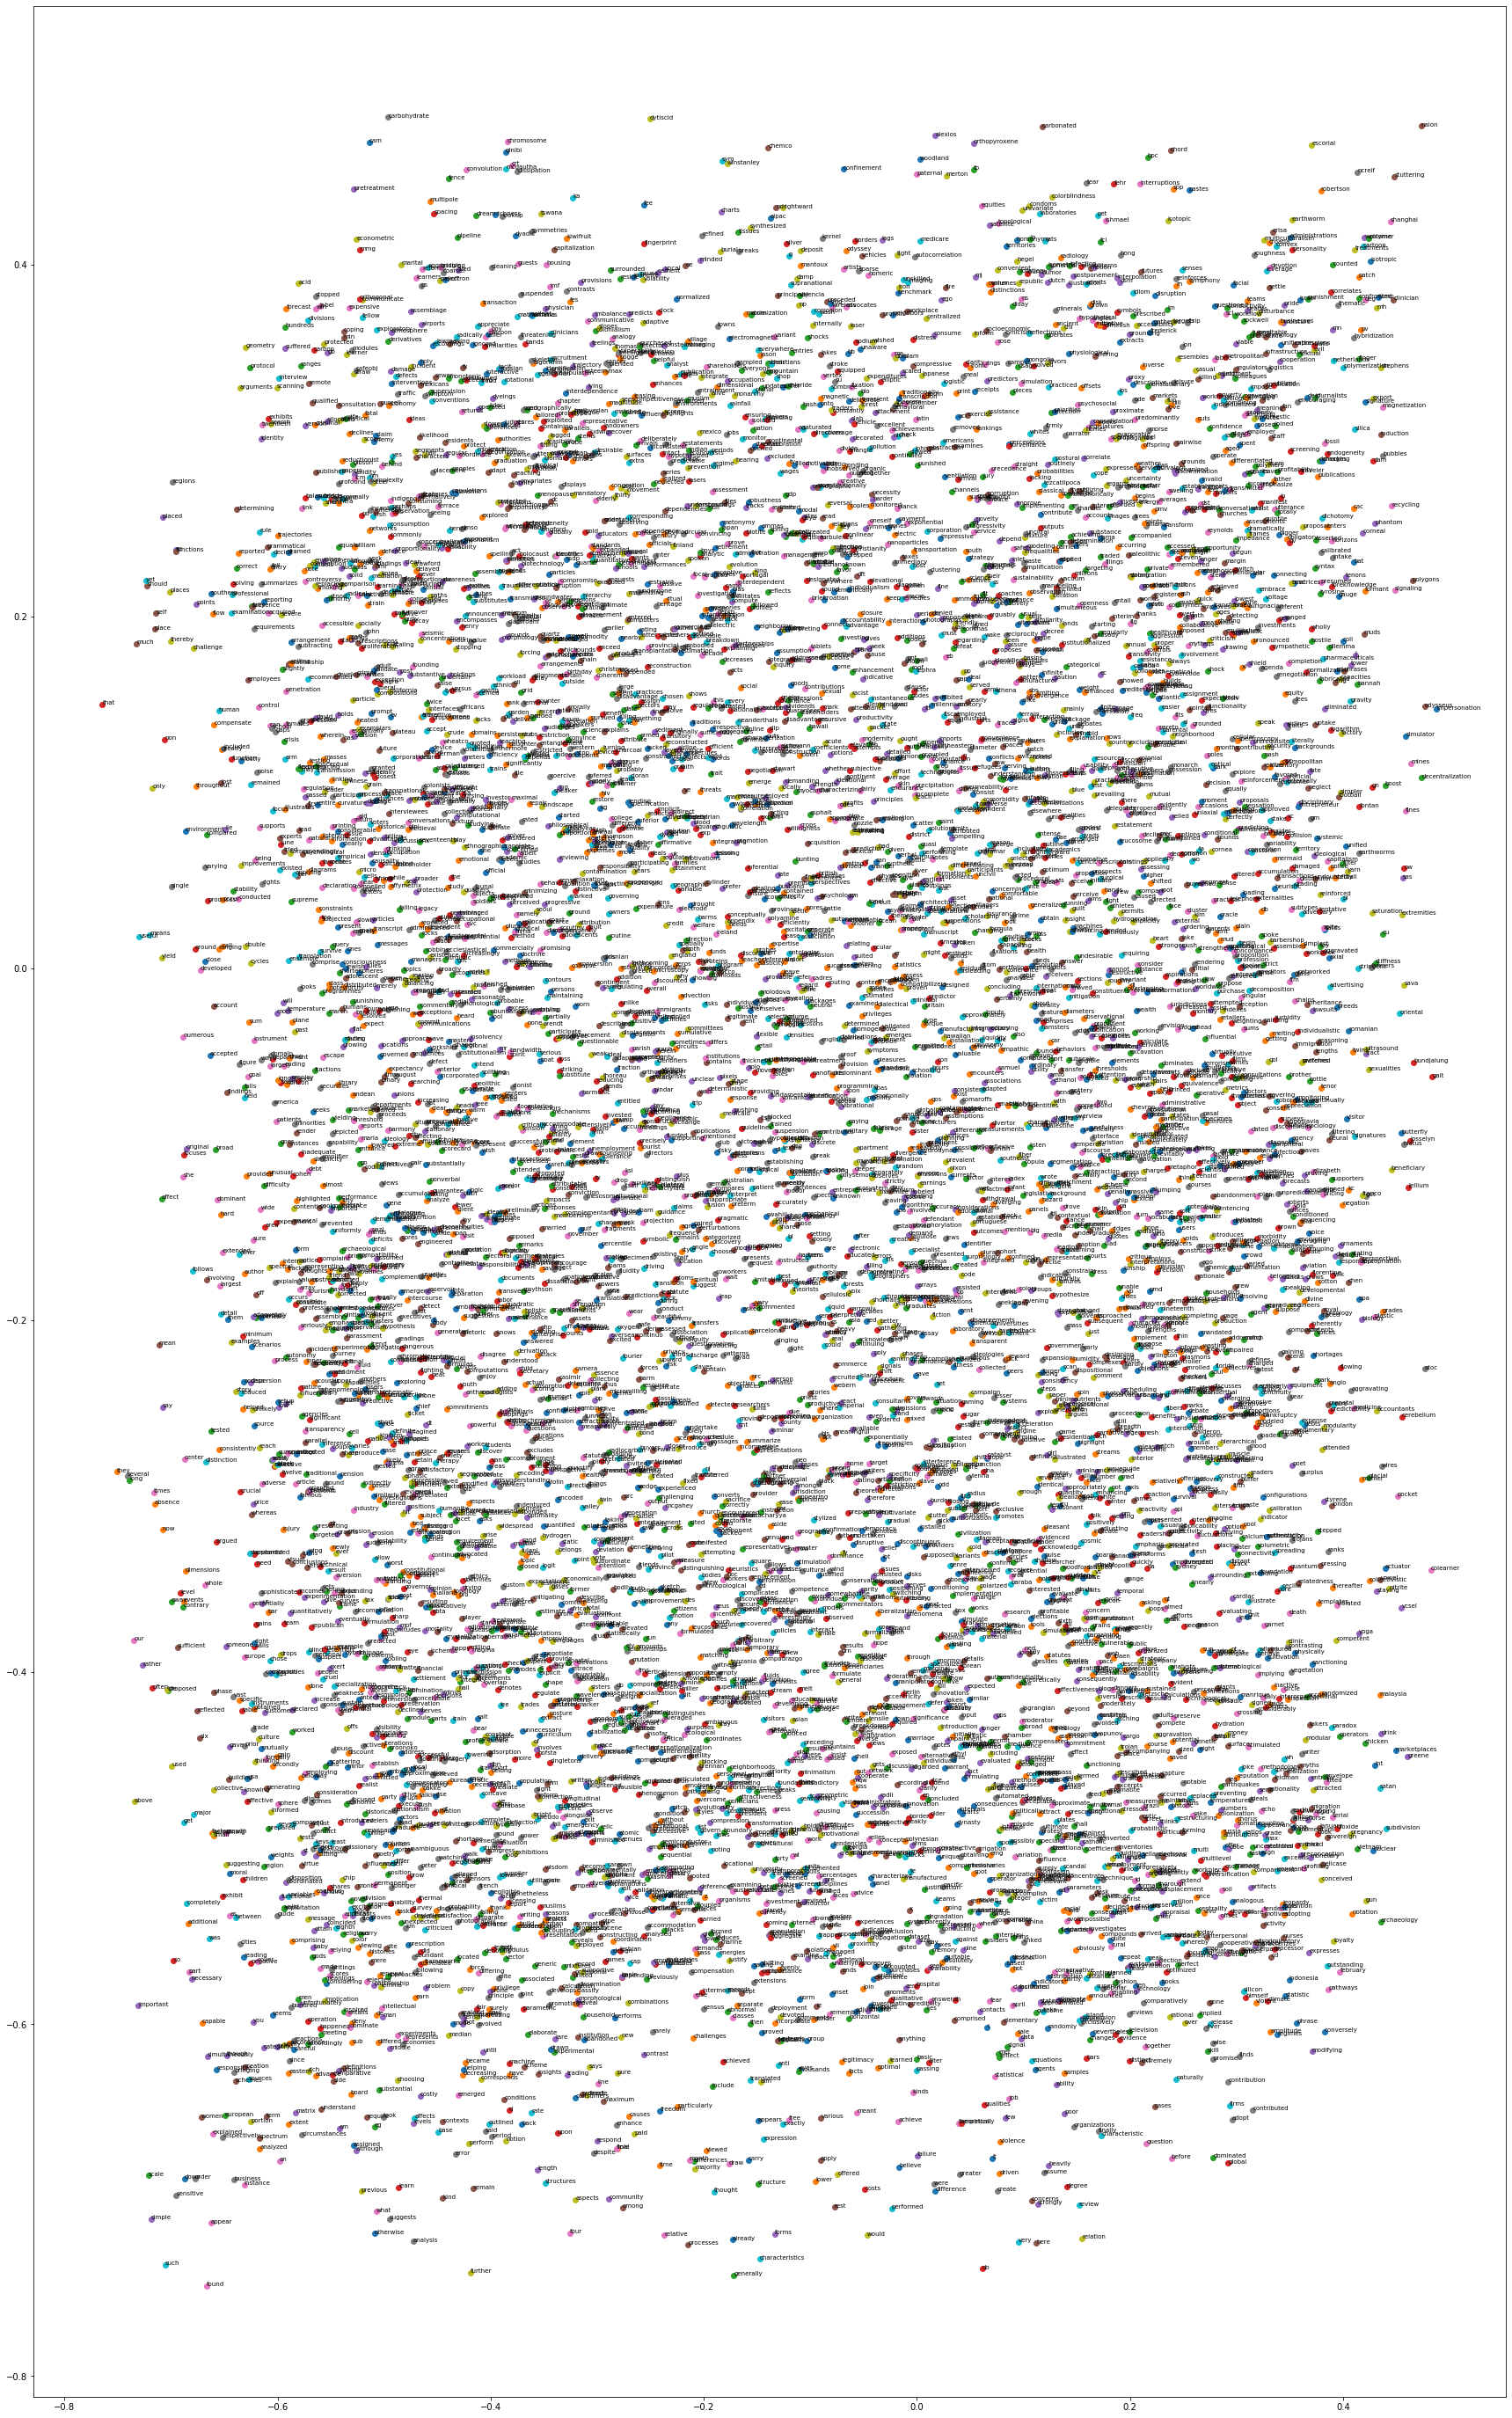

In [22]:
from matplotlib import pyplot as plt
plt.figure(figsize=(30, 50))
for x,y,word in outvec:
    plt.scatter(x,y)
    plt.text(x, y, word, fontsize=7)